# Introduction

make graphs such that there is a clear center graph  and try to reconstruct that

### Ipython Notebook init

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1) # use 2 for more info

# Setting up the problem.

use bursi graphs.

cluster them

for one cluster, determine a center

-> train regressor on distance to that center.

see if we can reach it.

In [2]:
EXPERIMENTSIZE= 2000

#  bursi graphs: 
from eden.converter.graph.gspan import gspan_to_eden
from itertools import islice
def get_graphs(dataset_fname='../../toolsdata/bursi.pos.gspan', size=EXPERIMENTSIZE):
    return  islice(gspan_to_eden(dataset_fname),size)


# cluster 
from eden.graph import Vectorizer
vec=Vectorizer()
matrix=vec.transform(get_graphs())

from sklearn.cluster import KMeans
n_clusters=5
clusterengine=KMeans(n_clusters=n_clusters)
ids=clusterengine.fit_predict(matrix)


[(465, 0), (437, 1), (404, 4), (401, 2), (293, 3)]
TARGET:


/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


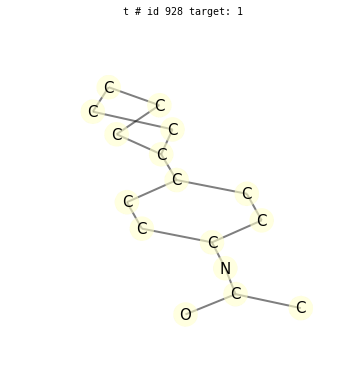

In [3]:
from sklearn.metrics.pairwise import euclidean_distances as dist
#http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.euclidean_distances.html
import copy

# get biggest cluster and its center
ids=list(ids)
li=[]
for i in range(n_clusters):
    li.append((  ids.count(i),i ))
li.sort(reverse=True)
print li
biggest_cluster=li[0][1]
center = clusterengine.cluster_centers_[biggest_cluster]

# get relevant graphs
clustergraphs=[]
restgraphs=[]
graphs=list(  get_graphs() )
for gid, cluster in enumerate(ids):
    if cluster==biggest_cluster:
        clustergraphs.append(graphs[gid])
    else:
        restgraphs.append(graphs[gid])
    
        
def get_graphs():
    # from here on out its only our new graphs
    # making sure nobody destroys our beauty by deepcopying
    return copy.deepcopy(clustergraphs)

# find graph closest to center:
matrix= vec.transform(get_graphs()) 
closest = dist( matrix, center).argmin()

#  regress on distances to center graph:
'''
distances_to_centergraph=dist(matrix,matrix[closest])
maxdist = distances_to_centergraph.max()
distances_to_centergraph = list(distances_to_centergraph.flatten())
regression_targets=[ maxdist-dist for dist in distances_to_centergraph ]
'''

# regress on rank ( of dist to centergraph):
'''
# get distances to center
distances_to_centergraph = dist(matrix,matrix[closest])
distances_to_centergraph = list(distances_to_centergraph.flatten())
# order by distance, farthest first 
dist_rank_list =  [ (dist,i)  for i,dist in enumerate(distances_to_centergraph)]
dist_rank_list.sort(reverse=True)
#sort by id but remember the rank..
regression_targets = [ (ind,rank)  for rank,(dist,ind) in enumerate( dist_rank_list )  ]
regression_targets.sort()
# then remove the id because its ascendingly clear :)
lentarg = float( len(regression_targets) )
regression_targets = [rank/lentarg for ind,rank in regression_targets]
'''


#  regress on new distance method
import copy

class sparse:
    def __init__(self,vector):
        self.size=sum(vector.data)
        self.data={ a:b for a,b in zip(vector.indices,vector.data)}
        self.maa=float(self.similarity(self))

    def similarity(self,other):
        #score  = sum([  1 for k,v in self.data.items() if k in other.data ])
        score  = sum([  v - abs(v-other.data[k])for k,v in self.data.items() if k in other.data ])
        score -= abs(other.size - self.size)*2
        return score
    
    def similarity_normalized(self,other):
        score  = self.similarity(other)
        interm=score/self.maa
        return interm/2.0+.5
        
def graph_similarity_new(graphs, graph):
    graphs=copy.deepcopy(graphs)
    graph=copy.deepcopy(graph)
    from eden.graph import Vectorizer
    vectorizer = Vectorizer(normalization=False,inner_normalization=False,complexity=2 )
    master = sparse(  vectorizer.transform([  graph  ])  )
    rest = [  sparse(vec) for vec in vectorizer.transform(graphs) ]
    return [ master.similarity_normalized(other) for other in rest ]

regression_targets=graph_similarity_new(get_graphs(),get_graphs()[closest])



import graphlearn.utils.draw as draw
print 'TARGET:'
draw.graphlearn(get_graphs()[closest])

In [4]:
%%time
from graphlearn.graphlearn import  Sampler
from graphlearn import estimate
from eden.graph import Vectorizer

# sample parameters
n_steps=300 # how many steps
n_samples=4 # collect this many samples during the process

sampler=Sampler(
                estimator=estimate.OneClassEstimator(nu=.7, cv=4, n_jobs=-1),
                #estimator=estimate.Regressor(),
                #vectorizer=Vectorizer(complexity=4),
                #grammar=LocalSubstitutableGraphGrammar(radius_list=[0,1], thickness_list=[1,2], min_cip_count=2,min_interface_count=2),
                        n_steps=n_steps, n_samples=n_samples,
                        probabilistic_core_choice=False, # if no opt are set, cores are chosen completely randomly...
                        score_core_choice= False,
                        size_diff_core_filter=12, # obviously we want to change the size
                        burnin=10,
                        include_seed=True,
                        proposal_probability = False,
                        improving_threshold_fraction=.5, 
                        improving_linear_start_fraction=0.0,
                        accept_static_penalty=0.0,
                        n_jobs=1,
                        select_cip_max_tries=200,
                        keep_duplicates=True,  
                        monitor=True
               )

decomposers = sampler.fit_make_decomps( get_graphs() )
sampler.fit_grammar(decomposers)
sampler.fit_estimator(decomposers,regression_targets=regression_targets)


# lets look at a few stats about the trained sampler
print('graph grammar stats:')
n_instances, interface_counts, core_counts, cip_counts = sampler.grammar().size()
print('#instances: %d   #interfaces: %d   #cores: %d   #core-interface-pairs: %d' % (n_instances, interface_counts, core_counts, cip_counts))

# dumps the sampler for later use. This is not mandatory :) 
sampler.save('../../tmp/sampler.ge')

graph grammar stats:
#instances: 465   #interfaces: 269   #cores: 93   #core-interface-pairs: 1021
CPU times: user 36.3 s, sys: 3.18 s, total: 39.5 s
Wall time: 40.2 s


# Grammar Inspection

If you are interested in the generated grammar, there are 
two useful tools available. 
You can draw the grammar directly, as seen below.
draw_grammar_stats will collect statistics about the grammar and visualize them nicely.

interface id: 540114 [32 options]


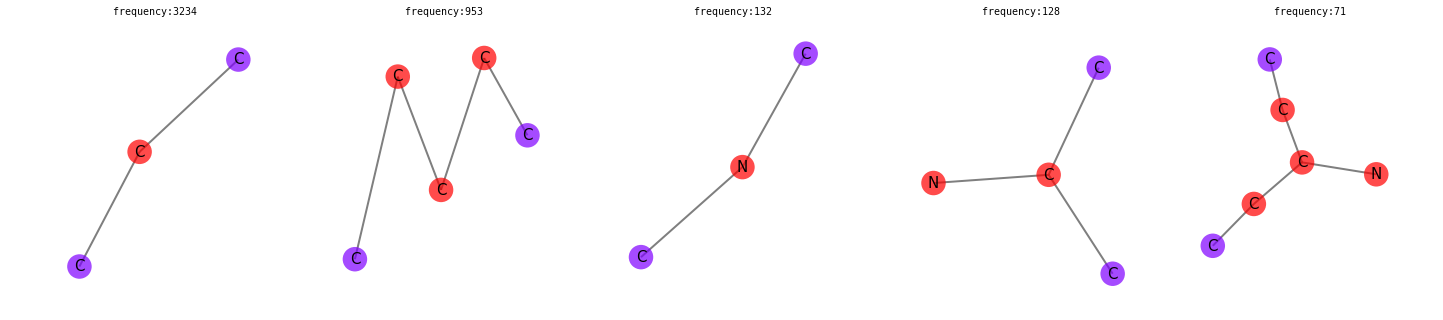

interface id: 790444 [29 options]


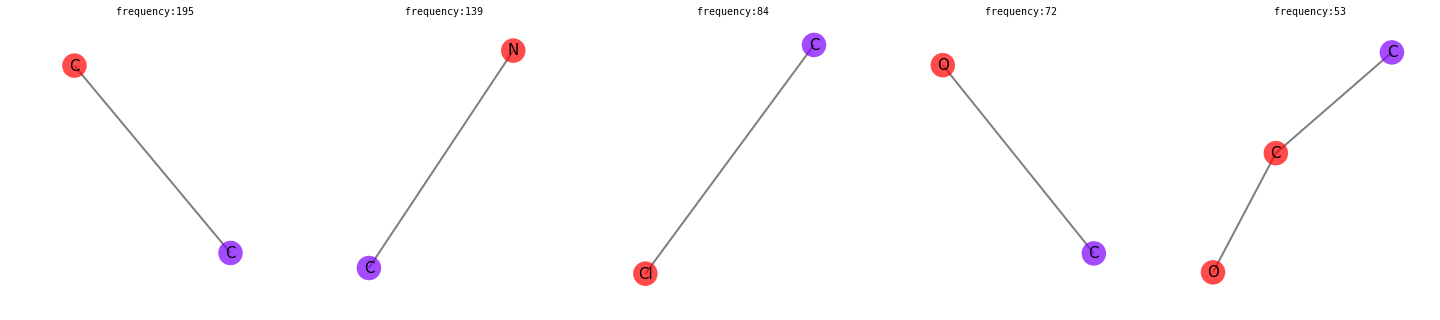

interface id: 406004 [28 options]


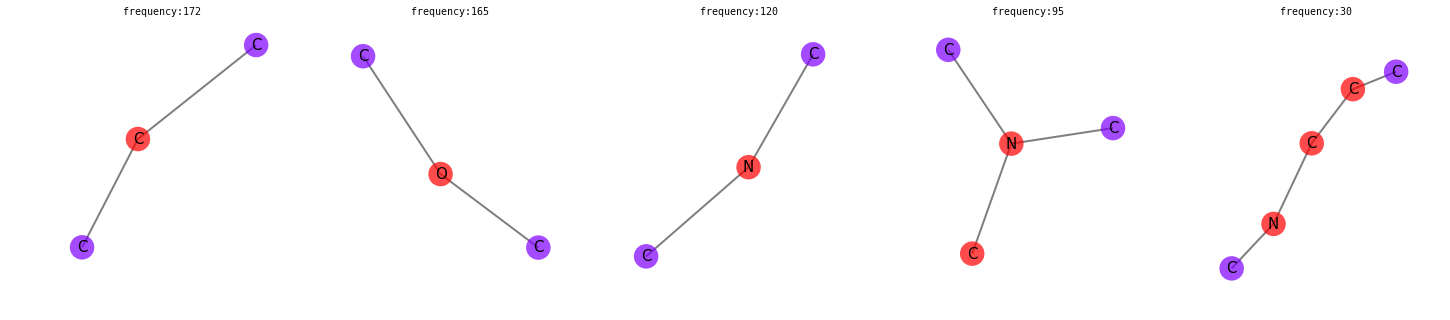

interface id: 698530 [25 options]


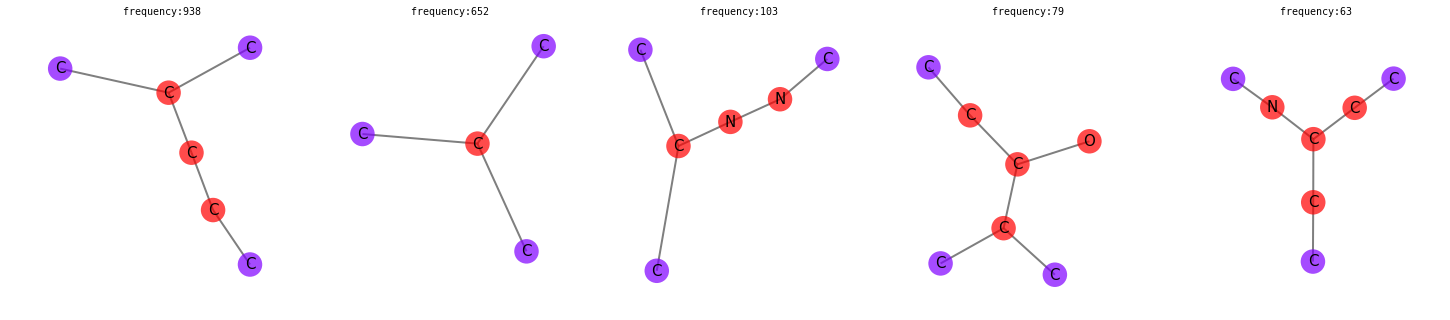

interface id: 298860 [20 options]


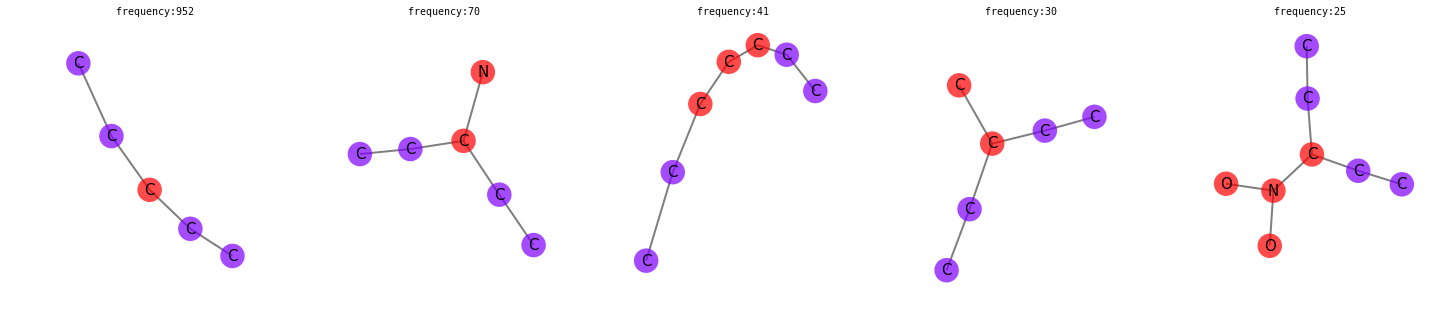

interface id: 761148 [18 options]


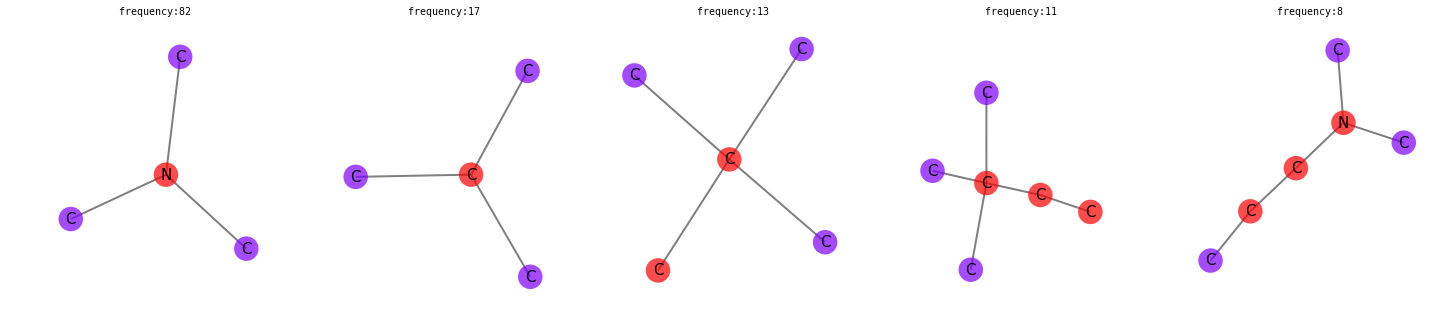

interface id: 324658 [18 options]


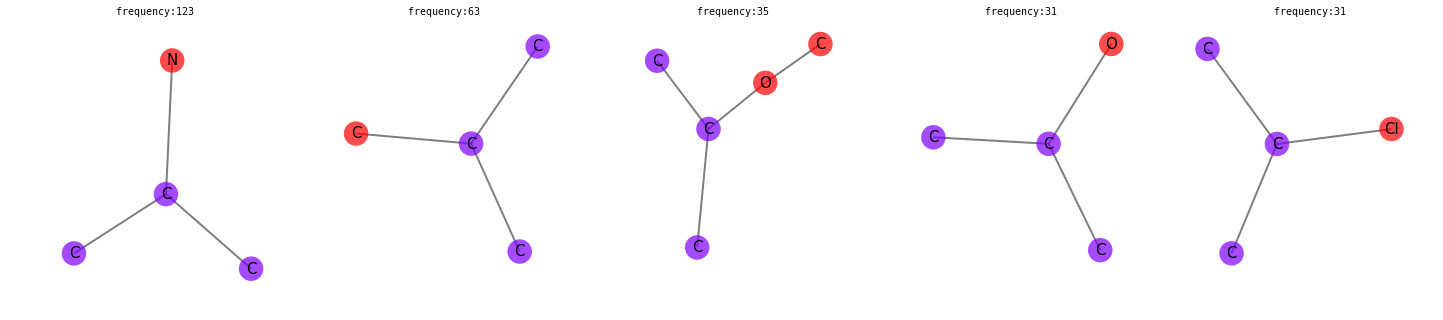

In [5]:
from graphlearn.utils.draw import draw_grammar
# draw one group of graph fragments (CIPS)
draw_grammar(sampler.grammar().productions, contract=True,
             n_productions=7,
             n_graphs_per_line=5,
             n_graphs_per_production=5,
             size=5, 
             colormap='rainbow',  
             vertex_alpha=0.7, 
             edge_alpha=0.5)
#from graphlearn.utils.draw import draw_grammar_stats
#draw_grammar_stats(sampler.lsgg.productions, size=(10,5))

# Sample

Sampling with default options will work just fine if you are just interested
in new graphs. The n_steps parameter defines 
how many attempts of altering a graph are made.

##### Options that will influence the acceptance of a generated graph:

In each sampling step, a graph is altered and scored.
An accept function decides if we keep the new graph. The parameters listed here 
influence this acceptance function.

improving_threshold=.5,
after this fraction of steps, only improvements are accepted  ---
improving_linear_start=0.0, 
graphs are accepted with a probability depending on their score. From this fraction it becomes gradually harder for worse graphs to be accepted. ---
accept_static_penalty=0.0, 
graphs that are worse than their predecessors get this penalty (on top of the other two options).

##### Options for choosing the new fragment:

The fragment chosen for alteration can be influenced by the acceptable node parameter (see sampler init). 
In general it will be chosen randomly. The fragment it will be replaced with can be influenced however:

probabilistic_core_choice=False, with this option we choose the fragment according to its frequency in the grammar.  ---
score_core_choice= True, choose the fragment according to score ( given by estimator ), the better the score, the more likely it is for a fragment to be picked ---
max_size_diff=1, maximum size difference between the seed graph and every graph generated graph. if choosing a fragment will violate the 
size constraints, it will not be selected.

#####  Output multiple graphs (along the sample path):


burnin=10, ignore the first burnin graphs for the nsamples parameter ---
n_samples=n_samples, from burnin to end of sample, collect this many samples. ---
keep_duplicates=True, duplicates may be deleted ---
include_seed=True,  seed will be the first graph in the output list. 

##### Collect additional information during sampling, that may help debugging

monitor=True, after sampling acessible via eg sampler.monitors[1][9] (first graph, ninth step)
                        
##### Output format 
sample() will yield a list of graph for each input graph.

In [6]:
%%time
from itertools import islice
from graphlearn.graphlearn import  Sampler
sampler=Sampler()
sampler.load('../../tmp/sampler.ge')

# picking graphs
graphs = get_graphs()
id_start=4
id_end=id_start+12
input_graphs = islice(graphs,id_start,id_end)

graphs = sampler.transform(input_graphs)

CPU times: user 580 ms, sys: 20 ms, total: 600 ms
Wall time: 598 ms


Graph id: 4


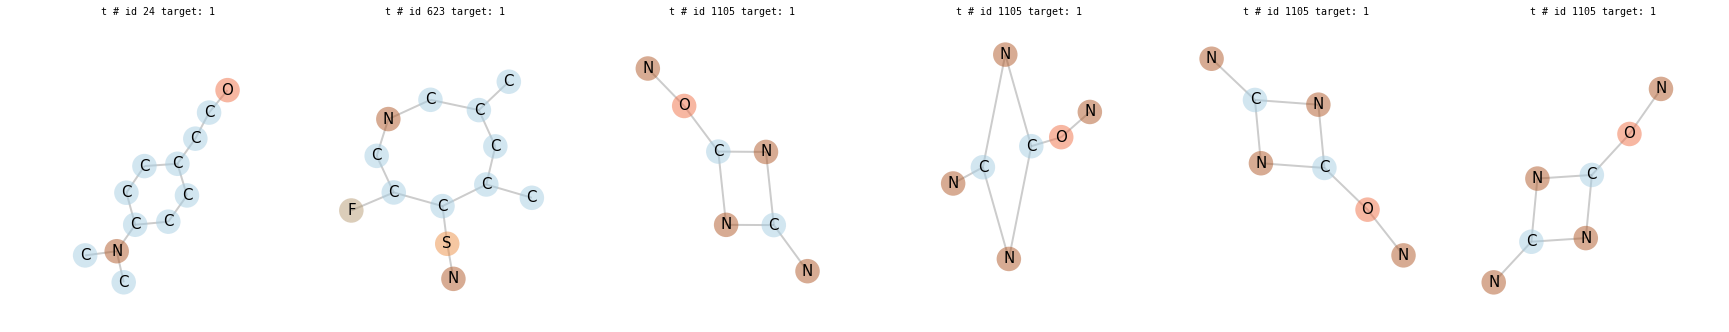

Graph id: 5


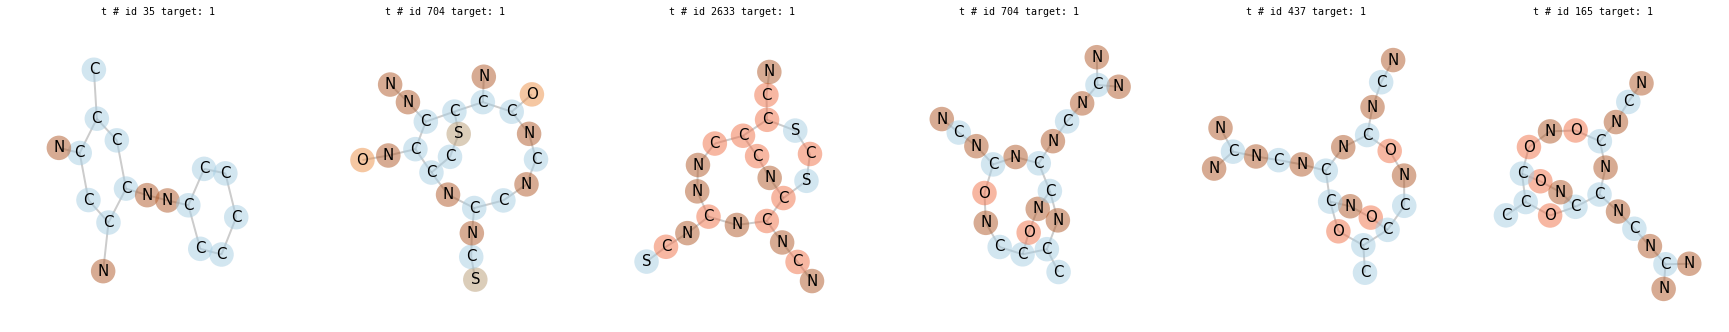

Graph id: 6


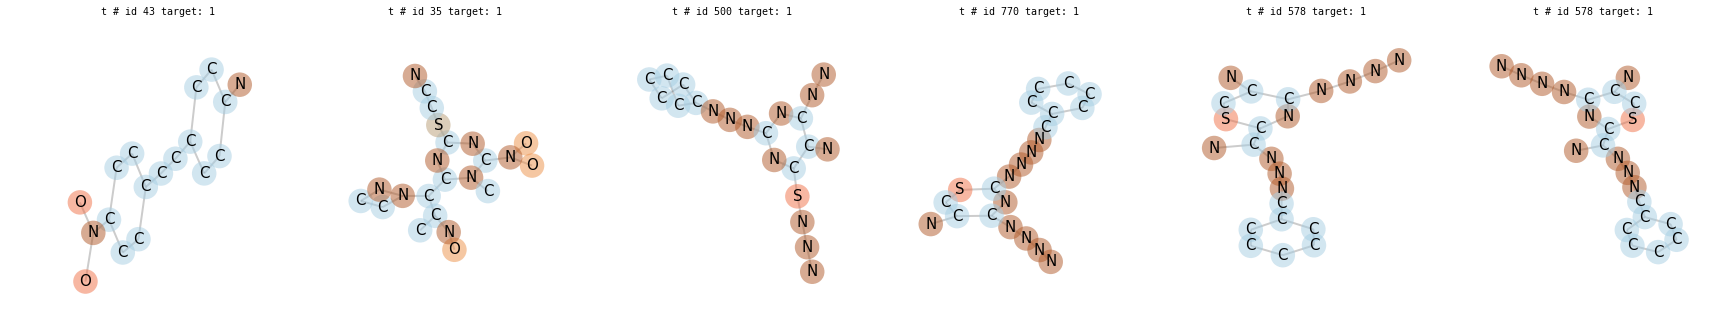

Graph id: 7


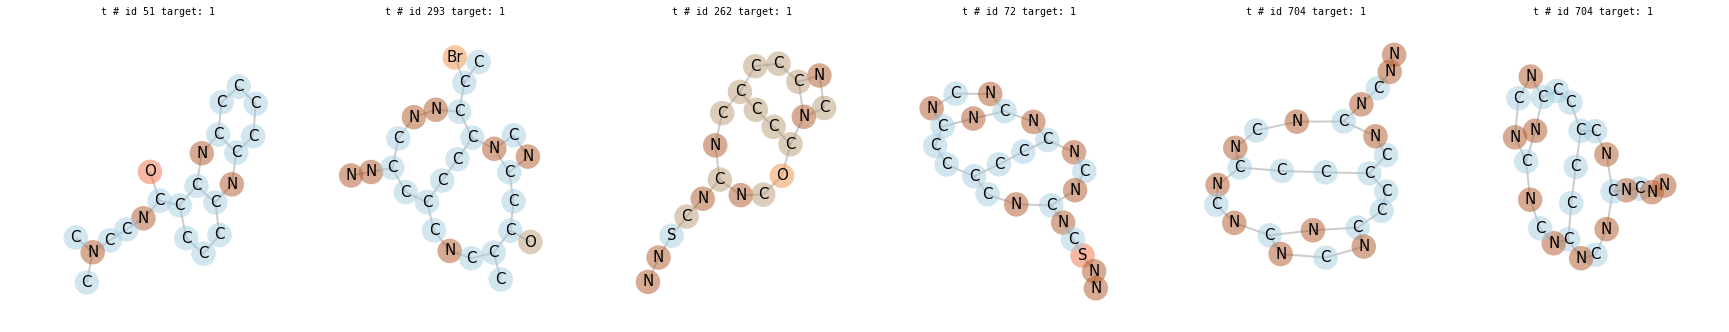

Graph id: 8


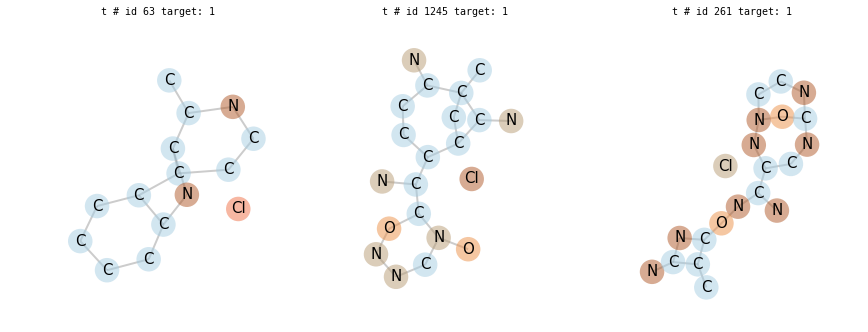

Graph id: 9


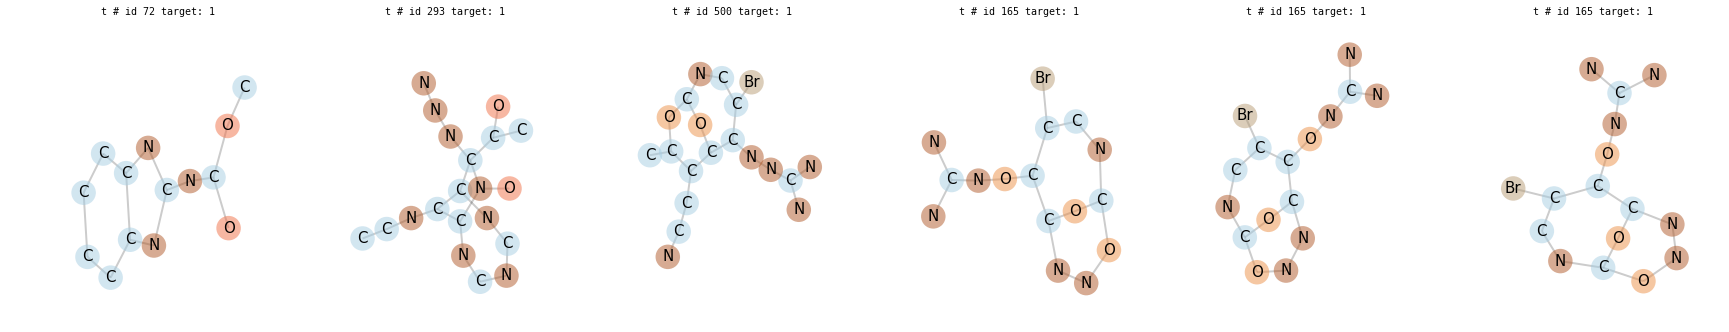

Graph id: 10


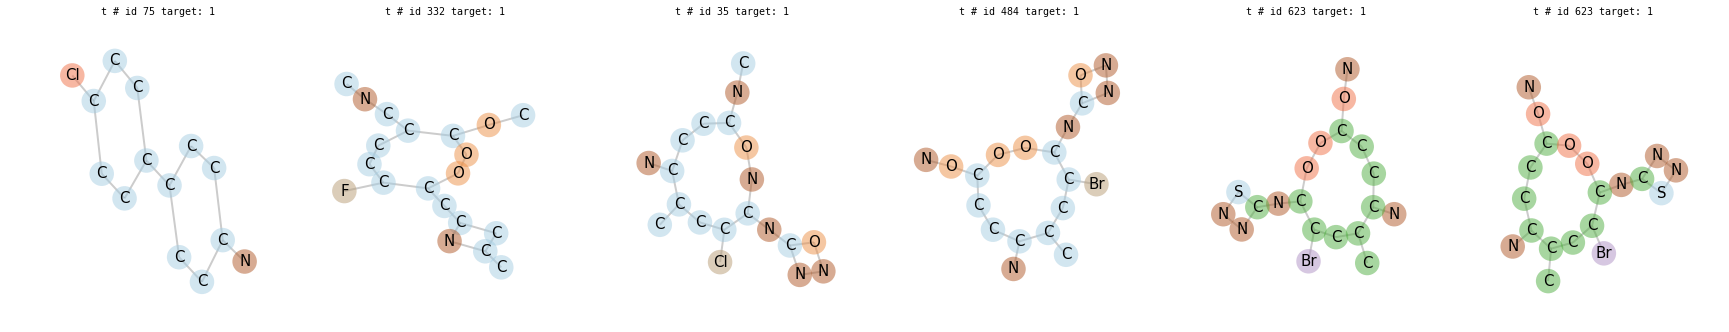

Graph id: 11


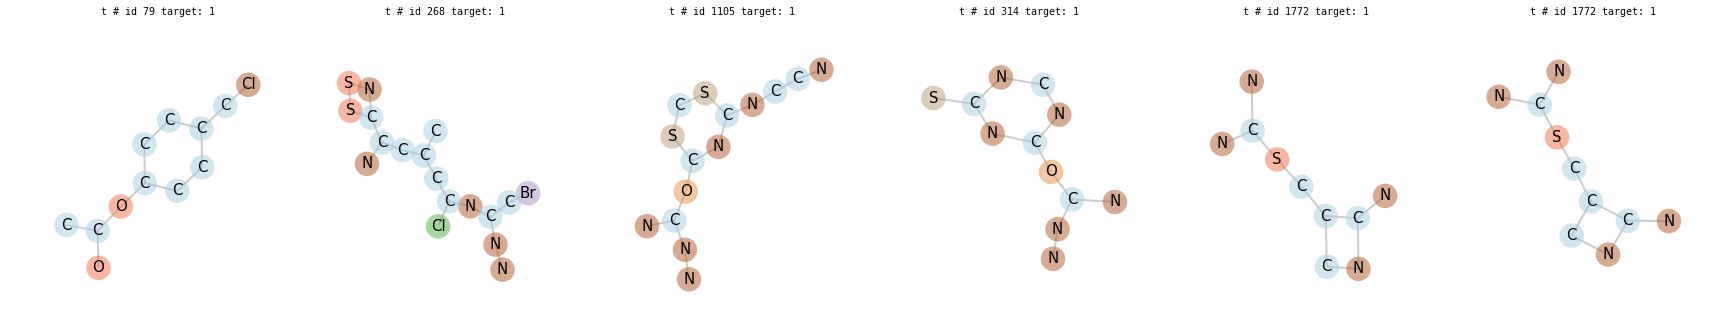

Graph id: 12


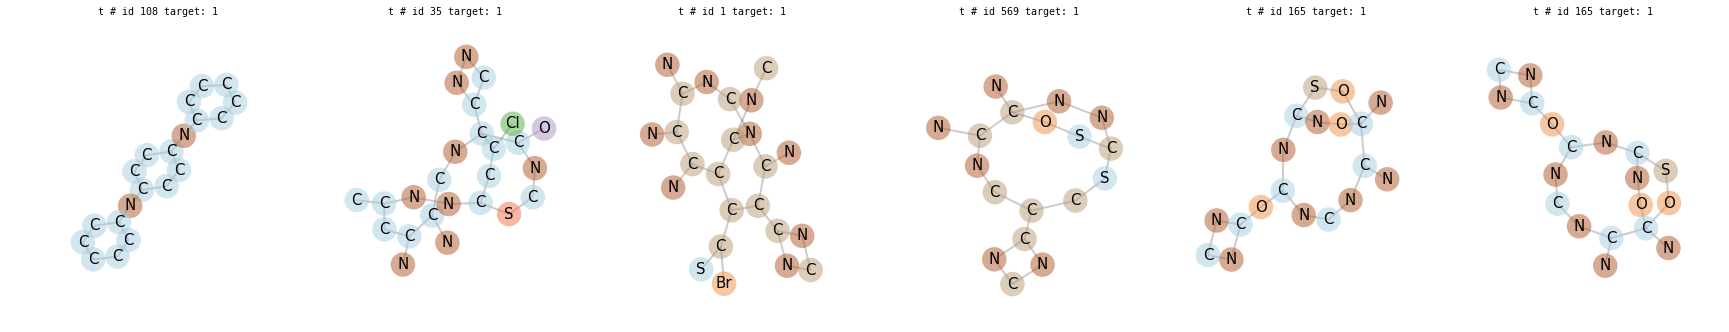

Graph id: 13


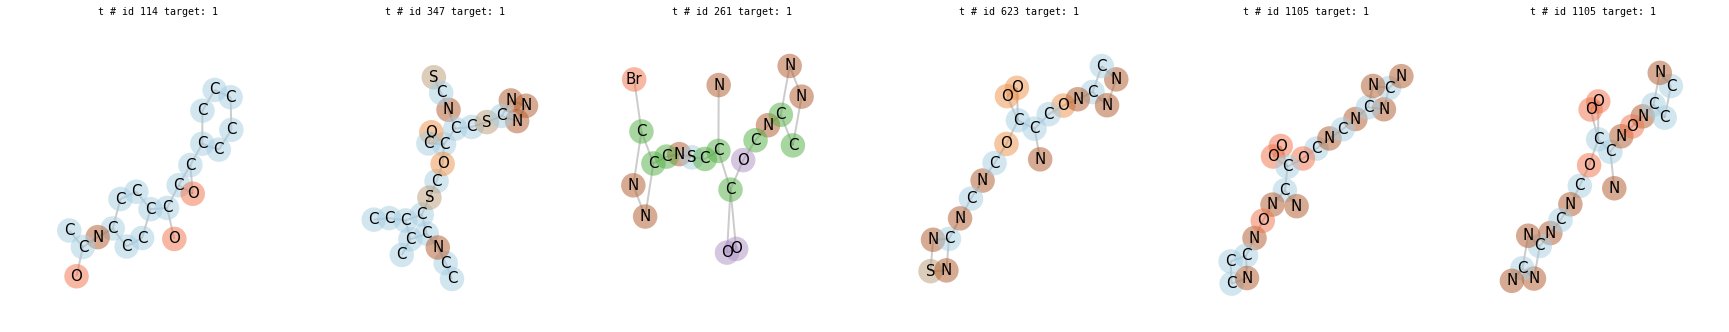

Graph id: 14


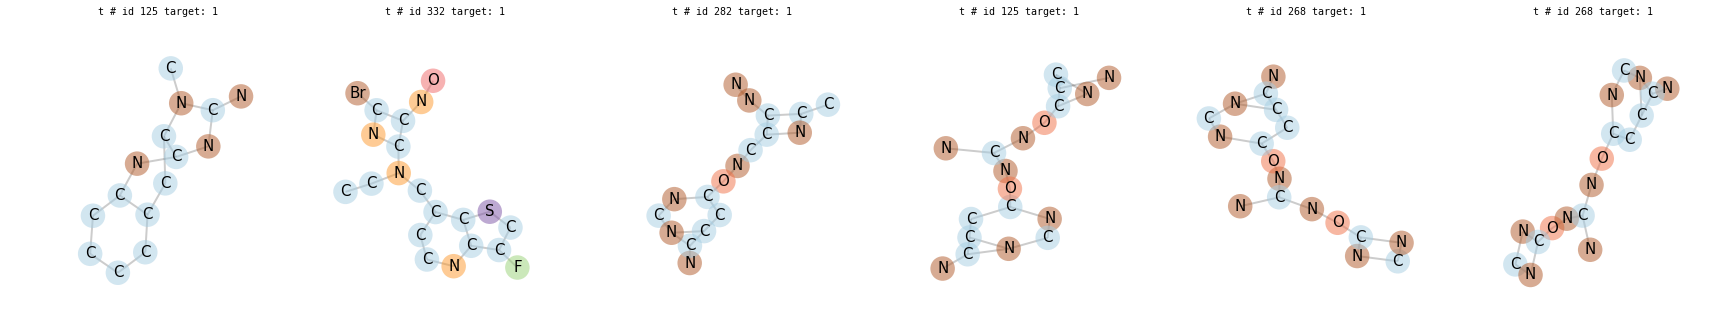

Graph id: 15


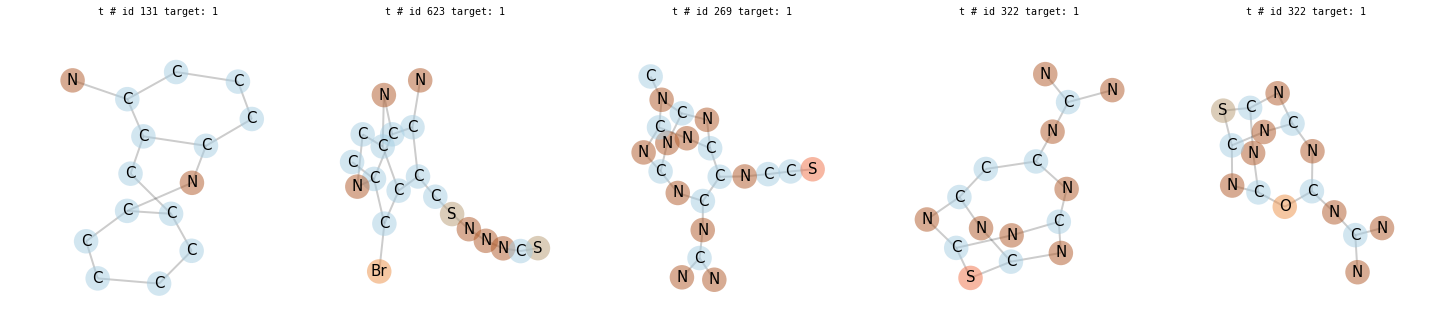

CPU times: user 37.6 s, sys: 916 ms, total: 38.5 s
Wall time: 40.6 s


In [7]:
%%time
BABELDRAW=False
# for each graphlist that is yielded by the sampler:
scores=[]
ids=range(id_start,id_end)
for i,graphlist in enumerate(graphs):
    
    # collect scores of each graph that appeared during the sampling 
    print 'Graph id: %d'%(ids[i])
    scores.append(sampler.monitors[i].sampling_info['score_history'])
    
    # choose a drawing method.
    #print [(extract_label_sequence(g),compare(extract_label_sequence(g),ref,flength)) for g in graphlist ]
    if BABELDRAW:
        # babel draw looks nice, but may lack detail
        from graphlearn.utils import openbabel
        openbabel.draw(graphlist, d3=False, n_graphs_per_line=6,size=200)
    else:
        from graphlearn.utils import draw
        # graphlearns drawing method is offering many options
        draw.graphlearn(graphlist,
                        contract=True,
                        n_graphs_per_line=6, 
                        size=5, 
                        colormap='Paired', 
                        invert_colormap=False,
                        vertex_color='_labels_',
                        vertex_alpha=0.5, 
                        edge_alpha=0.2)

# Show sample score history

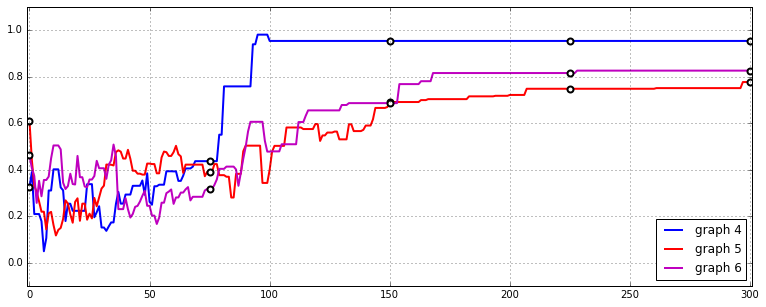

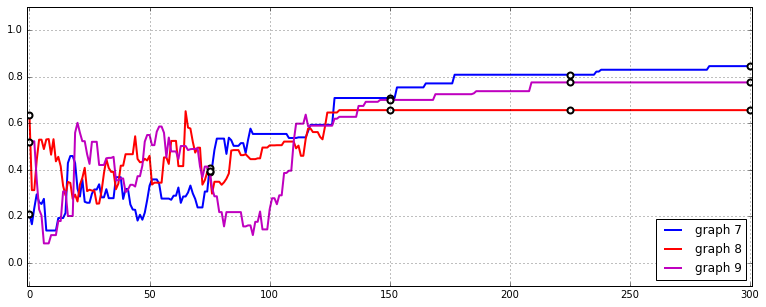

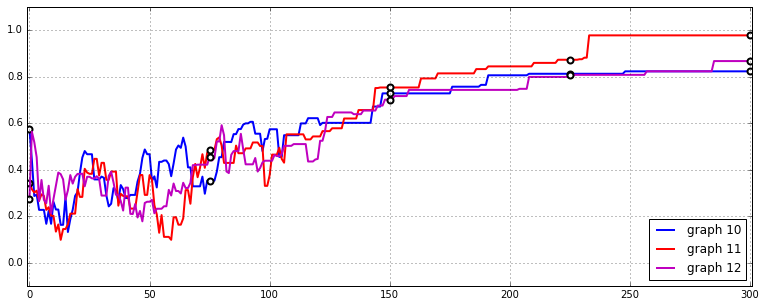

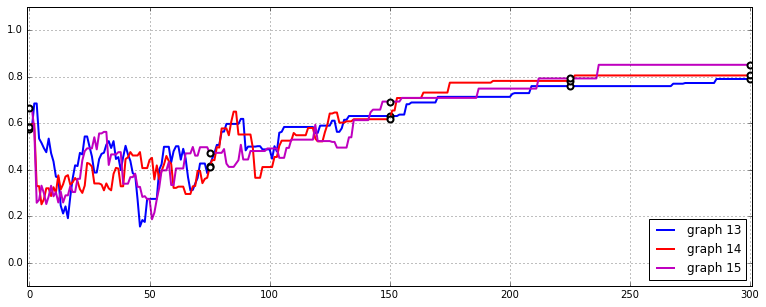

CPU times: user 508 ms, sys: 8 ms, total: 516 ms
Wall time: 512 ms


In [8]:
%%time
from itertools import islice
import numpy as np
import pylab as plt

markevery=n_steps/(n_samples)
step=1
num_graphs_per_plot=3
num_plots=np.ceil([len(scores)/num_graphs_per_plot])

for i in range(num_plots):
    plt.figure(figsize=(13,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
     
        data = list(islice(score,None, None, step))
        plt.plot(data, linewidth=2, label='graph %d'%(j+i*num_graphs_per_plot+id_start))
        plt.plot(data, linestyle='None',markevery=markevery, markerfacecolor='white', marker='o', markeredgewidth=2,markersize=6)
    plt.legend(loc='lower right')
    plt.grid()
    plt.xlim(-1,n_steps+1)
    plt.ylim(-0.1,1.1)
    plt.show()

---

 dist to center  [105, 106, 107, 108, 109, 104, 103, 102, 101]
dist -- id 

NameError: name 'dist_rank_list' is not defined